In [6]:
# Install streamlit for the web app
%pip install streamlit

Note: you may need to restart the kernel to use updated packages.


In [7]:
# Run this cell only if you haven't installed these already
%pip install -U efficientnet-pytorch albumentations opencv-python-headless scikit-learn matplotlib
# If you already have albumentations v2.x, ToTensorV2 import path used below is compatible.


Note: you may need to restart the kernel to use updated packages.


In [8]:
%pip install -U efficientnet-pytorch albumentations opencv-python-headless scikit-learn matplotlib --user


Note: you may need to restart the kernel to use updated packages.


In [9]:
!python -m pip install --upgrade pip --user


In [10]:
import os
import pandas as pd


In [11]:
# Cell 1 — imports
import os
import pandas as pd


In [12]:
# Cell 1 — imports, seed, device
import os
import random
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix

# Albumentations import for v2.x
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# EfficientNet
from efficientnet_pytorch import EfficientNet

# reproducibility
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [13]:
# Cell 2 — load CSVs
train_df = pd.read_csv('data/train.csv')
test_df  = pd.read_csv('data/test.csv')
sample_sub = pd.read_csv('data/sample_submission.csv')

# Create filepath column (change path if your images live elsewhere)
train_df['filepath'] = train_df['id_code'].apply(lambda x: os.path.join('data', 'train_images', f"{x}.png"))
test_df['filepath']  = test_df['id_code'].apply(lambda x: os.path.join('data', 'test_images', f"{x}.png"))

# quick check
print("Train samples:", len(train_df))
print(train_df.sample(3))


Train samples: 3662
           id_code  diagnosis                            filepath
2059  90960ddf4d14          0  data\train_images\90960ddf4d14.png
1105  4e0656629d02          1  data\train_images\4e0656629d02.png
818   3b018e8b7303          3  data\train_images\3b018e8b7303.png


In [14]:
# Cell 3 — stratified train/val split
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['diagnosis'])
train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop=True)

print("Train:", len(train_df), "Val:", len(val_df))



Train: 2929 Val: 733


In [15]:
cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)

IMG_SIZE = 224  # or 260 for EfficientNet-B2

train_transforms = A.Compose([
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8,8), p=0.3),              
    A.RandomResizedCrop(size=(IMG_SIZE, IMG_SIZE), scale=(0.8, 1.0), p=1.0),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.4),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, p=0.5),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])

val_transforms = A.Compose([
    A.Resize(width=IMG_SIZE, height=IMG_SIZE),
    A.CenterCrop(height=IMG_SIZE, width=IMG_SIZE),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])


In [16]:
# Cell 5 — dataset
class RetinopathyDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_path = row['filepath']
        # read BGR -> convert to RGB
        img = cv2.imread(img_path)
        if img is None:
            # fallback in case file missing
            img = np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=img)
            img = augmented['image']
        label = torch.tensor(int(row['diagnosis']), dtype=torch.long)
        return img, label


In [17]:
# Cell 6 — create dataset and dataloader
train_ds = RetinopathyDataset(train_df, transform=train_transforms)
val_ds   = RetinopathyDataset(val_df,   transform=val_transforms)

# Compute class weights for sampler & loss
class_counts = train_df['diagnosis'].value_counts().sort_index().values
print("Class counts:", class_counts)
class_weights = compute_class_weight('balanced', classes=np.arange(len(class_counts)), y=train_df['diagnosis'])
print("Class weights:", class_weights)

# WeightedRandomSampler
sample_weights = class_weights[train_df['diagnosis'].values]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

batch_size = 8   # try 8 for CPU; lower if you run out of RAM
num_workers = 0  # set >0 on Linux; on Windows sometimes safer to use 0

train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=sampler, num_workers=num_workers, pin_memory=False)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=False)

print("Batches per epoch (train):", len(train_loader))


Class counts: [1444  296  799  154  236]
Class weights: [0.40567867 1.97905405 0.73316646 3.8038961  2.48220339]
Batches per epoch (train): 367


In [18]:
# Cell 7 — model setup
USE_B0_FOR_SPEED = False  # set True if you want faster training: EfficientNet-B0

if USE_B0_FOR_SPEED:
    model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=5)
else:
    model = EfficientNet.from_pretrained('efficientnet-b2', num_classes=5)

# move to device
model = model.to(device)
print(model)


Loaded pretrained weights for efficientnet-b2
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kern

In [19]:
# Cell 8 — freeze backbone, train head first
for name, param in model.named_parameters():
    param.requires_grad = False

# EfficientNet's final fc is model._fc
for param in model._fc.parameters():
    param.requires_grad = True

# Optionally unfreeze conv head too:
# for param in model._conv_head.parameters():
#     param.requires_grad = True

# Create optimizer that only updates trainable params
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.AdamW(trainable_params, lr=1e-3, weight_decay=1e-4)


In [20]:
# Cell 9 — loss function (weighted)
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)  # you can also try FocalLoss below

# Optional: focal loss
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super().__init__()
        self.gamma = gamma
        self.weight = weight

    def forward(self, logits, targets):
        ce = nn.functional.cross_entropy(logits, targets, weight=self.weight, reduction='none')
        pt = torch.exp(-ce)
        focal = ((1-pt)**self.gamma * ce).mean()
        return focal

# Example: criterion = FocalLoss(gamma=2.0, weight=weights_tensor)


In [21]:
# Cell 10 — scheduler
from torch.optim.lr_scheduler import CosineAnnealingLR

num_epochs = 10
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)


In [27]:
# Cell 11 — training + validation
import time
import os # <-- ADDED
os.makedirs("models", exist_ok=True) # <-- ADDED
best_val_acc = 0.0
best_qwk = -1.0
save_path = "models/best_model.pth" # <-- MODIFIED

for epoch in range(num_epochs):
    t0 = time.time()
    model.train()
    running_loss = 0.0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if batch_idx % 20 == 0:
            print(f"Epoch {epoch+1}/{num_epochs} — Batch {batch_idx}/{len(train_loader)} — Loss: {loss.item():.4f}")

    scheduler.step()

    # Validation
    model.eval()
    preds_all = []
    labels_all = []
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(labels.cpu().numpy())

    val_acc = accuracy_score(labels_all, preds_all) * 100.0
    try:
        qwk = cohen_kappa_score(labels_all, preds_all, weights='quadratic')
    except:
        qwk = -1.0

    print(f"Epoch {epoch+1} done in {time.time()-t0:.1f}s — Val Acc: {val_acc:.2f}% — QWK: {qwk:.4f}")

    # Save by QWK (preferred for ordinal DR)
    if qwk > best_qwk:
        best_qwk = qwk
        torch.save(model.state_dict(), save_path)
        print("Saved best model by QWK:", best_qwk)

print("Training finished. Best QWK:", best_qwk)


Epoch 1/10 — Batch 0/367 — Loss: 0.6893
Epoch 1/10 — Batch 20/367 — Loss: 1.0268
Epoch 1/10 — Batch 20/367 — Loss: 1.0268
Epoch 1/10 — Batch 40/367 — Loss: 1.2274
Epoch 1/10 — Batch 40/367 — Loss: 1.2274
Epoch 1/10 — Batch 60/367 — Loss: 1.8136
Epoch 1/10 — Batch 60/367 — Loss: 1.8136
Epoch 1/10 — Batch 80/367 — Loss: 0.6284
Epoch 1/10 — Batch 80/367 — Loss: 0.6284
Epoch 1/10 — Batch 100/367 — Loss: 1.2336
Epoch 1/10 — Batch 100/367 — Loss: 1.2336
Epoch 1/10 — Batch 120/367 — Loss: 1.5537
Epoch 1/10 — Batch 120/367 — Loss: 1.5537
Epoch 1/10 — Batch 140/367 — Loss: 0.9928
Epoch 1/10 — Batch 140/367 — Loss: 0.9928
Epoch 1/10 — Batch 160/367 — Loss: 0.5703
Epoch 1/10 — Batch 160/367 — Loss: 0.5703
Epoch 1/10 — Batch 180/367 — Loss: 0.5310
Epoch 1/10 — Batch 180/367 — Loss: 0.5310
Epoch 1/10 — Batch 200/367 — Loss: 1.2413
Epoch 1/10 — Batch 200/367 — Loss: 1.2413
Epoch 1/10 — Batch 220/367 — Loss: 1.1170
Epoch 1/10 — Batch 220/367 — Loss: 1.1170
Epoch 1/10 — Batch 240/367 — Loss: 0.7770
Ep

Using weighted CrossEntropy with class weights: [0.40567867 1.97905405 0.73316646 3.8038961  2.48220339]
Starting fine-tune: unfreezed last 6 blocks | epochs=6 | lr=0.0001
Epoch 1/6 — Batch 0/367 — Loss: 0.4191
Epoch 1/6 — Batch 0/367 — Loss: 0.4191
Epoch 1/6 — Batch 20/367 — Loss: 0.7795
Epoch 1/6 — Batch 20/367 — Loss: 0.7795
Epoch 1/6 — Batch 40/367 — Loss: 0.6889
Epoch 1/6 — Batch 40/367 — Loss: 0.6889
Epoch 1/6 — Batch 60/367 — Loss: 1.5982
Epoch 1/6 — Batch 60/367 — Loss: 1.5982
Epoch 1/6 — Batch 80/367 — Loss: 0.6576
Epoch 1/6 — Batch 80/367 — Loss: 0.6576
Epoch 1/6 — Batch 100/367 — Loss: 0.5018
Epoch 1/6 — Batch 100/367 — Loss: 0.5018
Epoch 1/6 — Batch 120/367 — Loss: 0.7036
Epoch 1/6 — Batch 120/367 — Loss: 0.7036
Epoch 1/6 — Batch 140/367 — Loss: 0.9833
Epoch 1/6 — Batch 140/367 — Loss: 0.9833
Epoch 1/6 — Batch 160/367 — Loss: 0.6184
Epoch 1/6 — Batch 160/367 — Loss: 0.6184
Epoch 1/6 — Batch 180/367 — Loss: 0.7554
Epoch 1/6 — Batch 180/367 — Loss: 0.7554
Epoch 1/6 — Batch 20

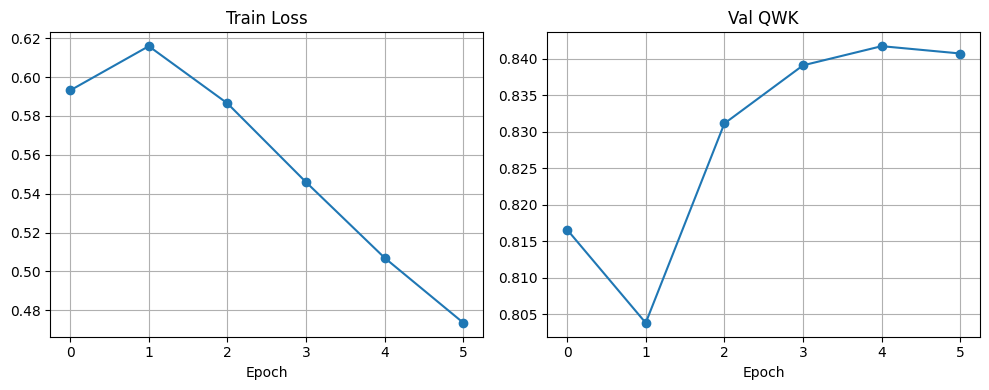

Done. If QWK improved, you have a saved model: models/best_model_finetuned.pth
If QWK did not improve, consider reducing n_blocks_to_unfreeze, lowering lr, or training longer.


In [28]:
# ===== Cell: Unfreeze last blocks & Fine-tune (paste and run) =====
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, cohen_kappa_score
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR

# ---- CONFIG ----
n_blocks_to_unfreeze = 6
finetune_epochs = 6
new_lr = 1e-4
weight_decay = 1e-5
grad_clip = 1.0
save_path = "models/best_model_finetuned.pth" # This is the correct path for the app

# ---- Safety checks ----
assert 'model' in globals(), "model not found — run model cell first"
assert 'train_loader' in globals() and 'val_loader' in globals(), "run DataLoader cells first"
assert 'device' in globals(), "device not set (run device cell)"

# ---- 1) Unfreeze last blocks of EfficientNet ----
def unfreeze_last_n_blocks(model, n_blocks=6):
    # EfficientNet-PyTorch stores blocks in model._blocks
    total_blocks = len(model._blocks)
    for i, block in enumerate(model._blocks):
        if i >= total_blocks - n_blocks:
            for param in block.parameters():
                param.requires_grad = True

# Unfreeze and also conv_head + fc
unfreeze_last_n_blocks(model, n_blocks=n_blocks_to_unfreeze)
for param in model._conv_head.parameters():
    param.requires_grad = True
for param in model._fc.parameters():
    param.requires_grad = True

# ---- 2) Recreate optimizer on currently trainable params ----
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.AdamW(trainable_params, lr=new_lr, weight_decay=weight_decay)
scheduler = CosineAnnealingLR(optimizer, T_max=finetune_epochs)

# ---- 3) Loss (recompute class weights from train_df to be safe) ----
try:
    labels = train_df['diagnosis'].values
    classes = np.unique(labels)
    class_weights = compute_class_weight('balanced', classes=classes, y=labels)
    weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights_tensor)
    print("Using weighted CrossEntropy with class weights:", class_weights)
except Exception as e:
    print("Could not compute class weights, using unweighted CE. Error:", e)
    criterion = nn.CrossEntropyLoss()

# ---- 4) Prepare training loop variables ----
best_qwk = globals().get('best_qwk', -1.0)   # if you have previous best, keep it
history = {'train_loss': [], 'val_acc': [], 'val_qwk': []}

# ---- 5) Fine-tune ----
print(f"Starting fine-tune: unfreezed last {n_blocks_to_unfreeze} blocks | epochs={finetune_epochs} | lr={new_lr}")
for epoch in range(finetune_epochs):
    t0 = time.time()
    model.train()
    running_loss = 0.0
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        # gradient clipping (helps stability)
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 20 == 0:
            print(f"Epoch {epoch+1}/{finetune_epochs} — Batch {batch_idx}/{len(train_loader)} — Loss: {loss.item():.4f}")

    scheduler.step()

    # ---- Validation ----
    model.eval()
    preds_all = []
    labels_all = []
    with torch.no_grad():
        for images, labels in val_loader:
            imgs = images.to(device)
            labs = labels.to(device)
            outs = model(imgs)
            _, preds = torch.max(outs, 1)
            preds_all.extend(preds.cpu().numpy())
            labels_all.extend(labs.cpu().numpy())

    val_acc = accuracy_score(labels_all, preds_all) * 100.0
    try:
        qwk = cohen_kappa_score(labels_all, preds_all, weights='quadratic')
    except:
        qwk = -1.0

    history['train_loss'].append(running_loss / len(train_loader))
    history['val_acc'].append(val_acc)
    history['val_qwk'].append(qwk)

    print(f"Epoch {epoch+1} finished in {time.time()-t0:.1f}s — TrainLoss: {running_loss/len(train_loader):.4f} — ValAcc: {val_acc:.2f}% — QWK: {qwk:.4f}")

    # ---- Save best by QWK (preferred for DR) ----
    if qwk > best_qwk:
        best_qwk = qwk
        torch.save(model.state_dict(), save_path)
        print("Saved new best model by QWK:", best_qwk)

print("Fine-tuning complete. Best QWK so far:", best_qwk)

# ---- 6) Quick plots (loss & QWK) ----
try:
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history['train_loss'], marker='o'); plt.title('Train Loss'); plt.xlabel('Epoch'); plt.grid(True)
    plt.subplot(1,2,2)
    plt.plot(history['val_qwk'], marker='o'); plt.title('Val QWK'); plt.xlabel('Epoch'); plt.grid(True)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Plotting failed (maybe no display):", e)

# ---- 7) Final tip printed for user ----
print("Done. If QWK improved, you have a saved model:", save_path)
print("If QWK did not improve, consider reducing n_blocks_to_unfreeze, lowering lr, or training longer.")


In [29]:
import os
os.makedirs("models", exist_ok=True)


In [30]:
torch.save(model.state_dict(), "models/best_model_finetuned.pth")
print("✅ Model saved at models/best_model_finetuned.pth")


✅ Model saved at models/best_model_finetuned.pth


In [33]:
from efficientnet_pytorch import EfficientNet
import torch

# Recreate model architecture (EfficientNet-B2 with 5 classes)
model = EfficientNet.from_pretrained('efficientnet-b2', num_classes=5)

# Load weights
model.load_state_dict(torch.load("models/best_model_finetuned.pth", map_location=device))
model = model.to(device)
model.eval()

print("✅ Model loaded and ready for inference!")


Loaded pretrained weights for efficientnet-b2
✅ Model loaded and ready for inference!


In [34]:
import cv2
from torchvision import transforms

# Choose a sample file
sample_path = "data/train_images/your_image.png"  # <-- replace with real file

# Load and preprocess
image = cv2.imread(sample_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

transform = val_transforms  # use validation transforms (no heavy augmentation)
tensor = transform(image=image)["image"].unsqueeze(0).to(device)

# Prediction
with torch.no_grad():
    outputs = model(tensor)
    probs = torch.softmax(outputs, dim=1)
    pred_class = torch.argmax(probs, dim=1).item()

print("Predicted Class:", pred_class)
print("Probabilities:", probs.cpu().numpy())


error: OpenCV(4.12.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [35]:
import os

train_dir = r"D:\Research\kaggle-demo\data\train_images"
print("Total files:", len(os.listdir(train_dir)))
print("Sample files:", os.listdir(train_dir)[:5])


Total files: 3662
Sample files: ['000c1434d8d7.png', '001639a390f0.png', '0024cdab0c1e.png', '002c21358ce6.png', '005b95c28852.png']


In [36]:
sample_path = r"D:\Research\kaggle-demo\data\train_images\000c1434d8d7.png"


In [37]:
# Load and preprocess
image = cv2.imread(sample_path)
if image is None:
    raise FileNotFoundError(f"Image not found at {sample_path}")

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

transform = val_transforms  # use validation transforms (no heavy aug)
tensor = transform(image=image)["image"].unsqueeze(0).to(device)

# Prediction
model.eval()
with torch.no_grad():
    outputs = model(tensor)
    probs = torch.softmax(outputs, dim=1)
    pred_class = torch.argmax(probs, dim=1).item()

print("✅ Predicted Class:", pred_class)
print("🔢 Probabilities:", probs.cpu().numpy())


✅ Predicted Class: 2
🔢 Probabilities: [[1.2782373e-06 8.9233657e-03 5.6157100e-01 4.2498643e-05 4.2946190e-01]]


In [2]:
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet

# Load model structure
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNet.from_name('efficientnet-b2', num_classes=5)

# Load trained weights
model.load_state_dict(torch.load("models/best_model_finetuned.pth", map_location=device))
model = model.to(device)
model.eval()

print("✅ Trained model loaded successfully!")


✅ Trained model loaded successfully!


In [38]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

IMG_SIZE = 224  # or 260 for EfficientNet-B2

val_transforms = A.Compose([
    A.Resize(height=IMG_SIZE, width=IMG_SIZE),
    A.CenterCrop(height=IMG_SIZE, width=IMG_SIZE),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ToTensorV2()
])


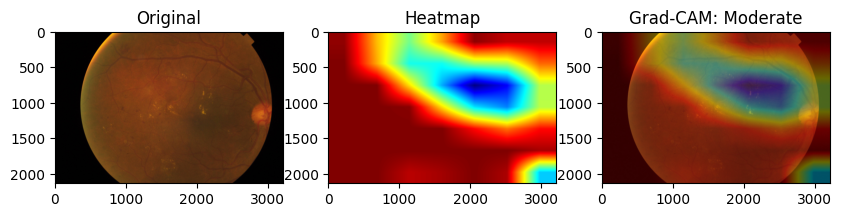

In [39]:
import torch
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ✅ Grad-CAM function
def show_gradcam(model, image_path, class_names, target_layer="_conv_head"):
    model.eval()

    # Load image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Preprocess (use val_transforms defined earlier)
    tensor = val_transforms(image=img)["image"].unsqueeze(0).to(device)

    # Forward & backward hooks
    gradients = []
    activations = []

    def forward_hook(module, inp, out):
        activations.append(out.detach())

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0].detach())

    # Register hooks
    layer = dict([*model.named_modules()])[target_layer]
    fwd = layer.register_forward_hook(forward_hook)
    bwd = layer.register_full_backward_hook(backward_hook)  # ✅ fixed

    # Forward pass
    outputs = model(tensor)
    pred_class = outputs.argmax(dim=1).item()

    # Backward pass for Grad-CAM
    model.zero_grad()
    one_hot = torch.zeros_like(outputs)
    one_hot[0, pred_class] = 1
    outputs.backward(gradient=one_hot)

    # Grad-CAM calculation
    grads = gradients[0].mean(dim=(2, 3), keepdim=True)
    cams = (activations[0] * grads).sum(dim=1, keepdim=True)
    cams = F.relu(cams)

    # Normalize CAM
    cam = cams[0, 0].cpu().numpy()
    cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

    # Overlay heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    # Show result
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Original")

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.title("Heatmap")

    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title(f"Grad-CAM: {class_names[pred_class]}")

    plt.show()

    # Remove hooks
    fwd.remove()
    bwd.remove()


# ✅ Example usage
class_names = ["No DR", "Mild", "Moderate", "Severe", "Proliferative DR"]
sample_path = r"D:\Research\kaggle-demo\data\train_images\000c1434d8d7.png"

show_gradcam(model, sample_path, class_names)


In [ ]:
!pip install seaborn


In [41]:
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms

# ------------------ Dataset Class ------------------
class RetinopathyDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_name = row['id_code'] + ".png"   # change to ".jpg" if your dataset uses jpg
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        label = int(row['diagnosis'])

        if self.transform:
            image = self.transform(image)

        return image, label

# ------------------ Load train.csv with full path ------------------
data_dir = r"D:\Research\kaggle-demo\data"
df = pd.read_csv(os.path.join(data_dir, "train.csv"))

# ------------------ Train/Validation Split ------------------
train_frac = 0.8
train_size = int(train_frac * len(df))
val_size = len(df) - train_size
train_df, val_df = random_split(df, [train_size, val_size])

# ------------------ Transforms ------------------
val_transforms = transforms.Compose([
    transforms.Resize((224,224)),   # same size used during training
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ------------------ Validation Dataset ------------------
val_ds = RetinopathyDataset(val_df.dataset.iloc[val_df.indices],
                            os.path.join(data_dir, "train_images"),
                            transform=val_transforms)

# ------------------ DataLoader ------------------
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0)

print("✅ Validation loader ready with", len(val_ds), "images")


✅ Validation loader ready with 733 images


In [42]:
import torch
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

print("✅ Predictions collected:", len(y_true))


✅ Predictions collected: 733


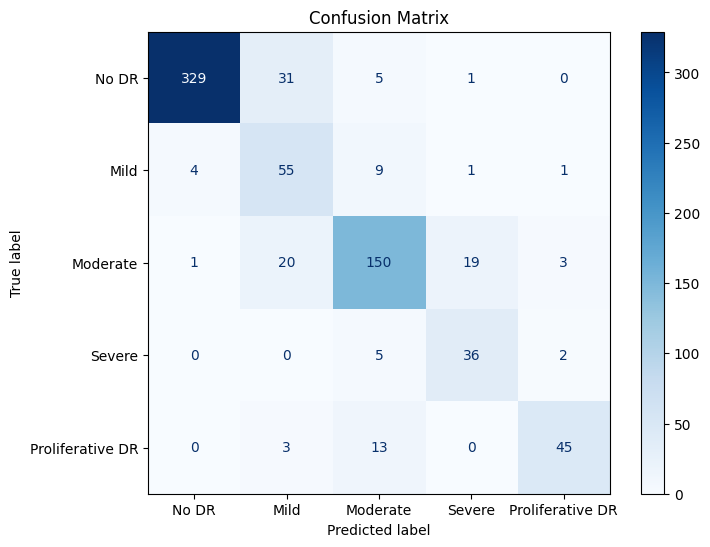

Classification Report:
                   precision    recall  f1-score   support

           No DR       0.99      0.90      0.94       366
            Mild       0.50      0.79      0.61        70
        Moderate       0.82      0.78      0.80       193
          Severe       0.63      0.84      0.72        43
Proliferative DR       0.88      0.74      0.80        61

        accuracy                           0.84       733
       macro avg       0.77      0.81      0.78       733
    weighted avg       0.87      0.84      0.85       733



In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

class_names = ["No DR", "Mild", "Moderate", "Severe", "Proliferative DR"]

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8,6))
disp.plot(cmap="Blues", ax=ax, values_format='d')
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))


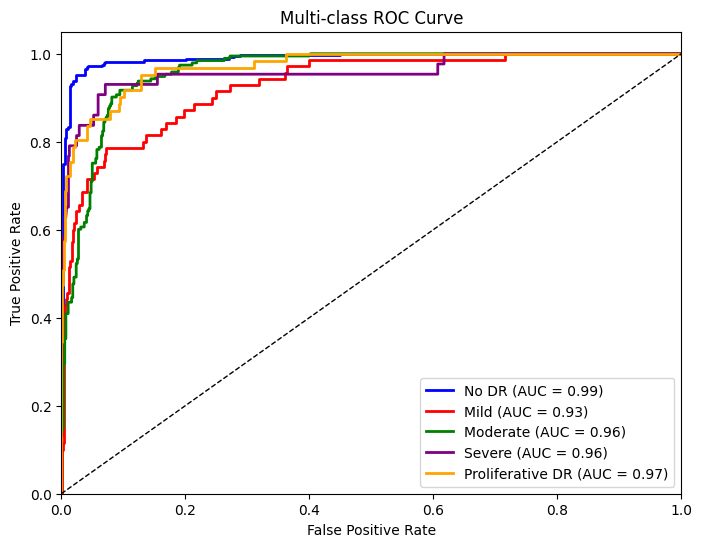

In [44]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# One-hot encode labels
y_true_bin = label_binarize(y_true, classes=[0,1,2,3,4])
n_classes = y_true_bin.shape[1]

fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8,6))
colors = cycle(["blue", "red", "green", "purple", "orange"])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curve")
plt.legend(loc="lower right")
plt.show()


In [ ]:
!pip install timm


   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.5 MB ? eta -:--:--
   -------- ------------------------------- 0.5/2.5 MB 1.9 MB/s eta 0:00:02
   ---------------- ----------------------- 1.0/2.5 MB 2.1 MB/s eta 0:00:01
   ----------------------------- ---------- 1.8/2.5 MB 2.3 MB/s eta 0:00:01
   ---------------------------------------- 2.5/2.5 MB 2.8 MB/s  0:00:00
   ---------------------------------------- 0.0/564.3 kB ? eta -:--:--
   ---------------------------------------- 564.3/564.3 kB 3.2 MB/s  0:00:00

   ------------- -------------------------- 1/3 [huggingface_hub]
   ------------- -------------------------- 1/3 [huggingface_hub]
   ------------- -------------------------- 1/3 [huggingface_hub]
   -------------------------- ------------- 2/3 [timm]
   -------------------------- ------------- 2/3 [timm]
   -------------------------- ------------- 2/3 [timm]
   -------------------------- ------------- 2/3 [

In [5]:
import torch
import timm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the same model architecture
model = timm.create_model("efficientnet_b2", pretrained=False, num_classes=5)

# Load checkpoint
checkpoint = torch.load("models/best_model_finetuned.pth", map_location=device)
model.load_state_dict(checkpoint, strict=False)

model.to(device)
model.eval()

print("✅ Model loaded successfully with timm EfficientNet-B2")


✅ Model loaded successfully with timm EfficientNet-B2


In [3]:
import torch
import timm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------- Reload your EfficientNet-B2 ----------------
model = timm.create_model("efficientnet_b2", pretrained=False, num_classes=5)

checkpoint = torch.load("models/best_model_finetuned.pth", map_location=device)
model.load_state_dict(checkpoint, strict=False)

model.to(device)
model.eval()

print("✅ Model reloaded successfully")

# ---------------- Pick the target layer ----------------
target_layer = model.conv_head  # last conv layer in EfficientNet-B2


✅ Model reloaded successfully


✅ Model reloaded successfully


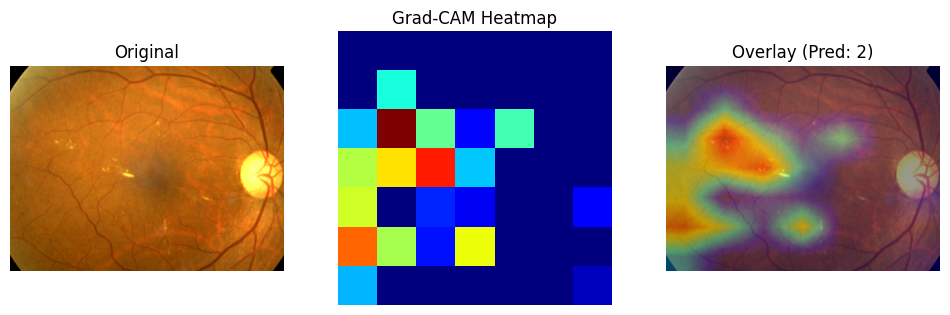

In [8]:
import torch
import timm
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import cv2
import warnings

warnings.filterwarnings("ignore", category=UserWarning)  # hide small hook warnings

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------- Reload EfficientNet-B2 ----------------
model = timm.create_model("efficientnet_b2", pretrained=False, num_classes=5)
checkpoint = torch.load("models/best_model_finetuned.pth", map_location=device)
model.load_state_dict(checkpoint, strict=False)
model.to(device)
model.eval()
print("✅ Model reloaded successfully")

# ---------------- Grad-CAM Hook Class ----------------
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks (no conflict since we use blocks[-1])
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate(self, input_tensor, target_class=None):
        output = self.model(input_tensor)
        if target_class is None:
            target_class = output.argmax(dim=1).item()

        self.model.zero_grad()
        loss = output[0, target_class]
        loss.backward()

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activations = self.activations.squeeze(0)

        for i in range(activations.shape[0]):
            activations[i, :, :] *= pooled_gradients[i]

        heatmap = torch.mean(activations, dim=0).cpu().numpy()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1
        return heatmap, target_class

# ---------------- Utility: Show Grad-CAM ----------------
def show_gradcam(img_path, model, target_layer):
    preprocess = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    img = Image.open(img_path).convert("RGB")
    input_tensor = preprocess(img).unsqueeze(0).to(device)

    gradcam = GradCAM(model, target_layer)
    heatmap, pred_class = gradcam.generate(input_tensor)

    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    heatmap_resized = cv2.resize(heatmap, (img_cv.shape[1], img_cv.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_cv, 0.6, heatmap_colored, 0.4, 0)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(heatmap, cmap="jet")
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title(f"Overlay (Pred: {pred_class})")
    plt.axis("off")

    plt.show()

# ---------------- Run on a test image ----------------
test_img_path = r"D:\Research\kaggle-demo\data\test_images\0a262e8b2a5a.png"

# ✅ Use the last block instead of conv_head
target_layer = model.blocks[-1]  
show_gradcam(test_img_path, model, target_layer)


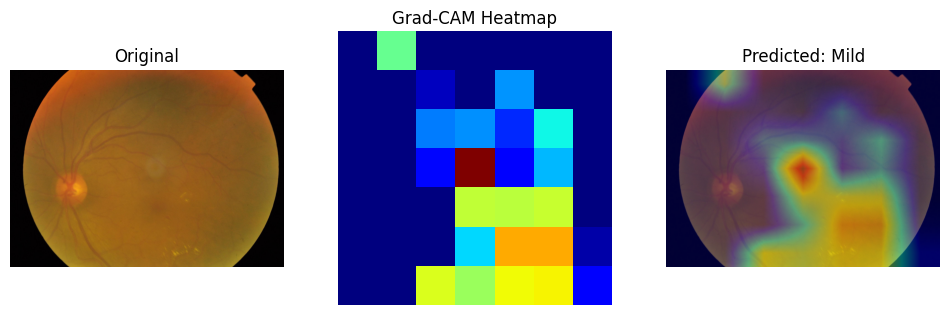

✅ Image: 0e052b0dec40.png | Predicted class: Mild


In [11]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import cv2

# ---------------- Predict Single Image with Explainability ----------------
def predict_single_image(img_path, model, target_layer):
    class_names = ["No DR", "Mild", "Moderate", "Severe", "Proliferative DR"]

    preprocess = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    img = Image.open(img_path).convert("RGB")
    input_tensor = preprocess(img).unsqueeze(0).to(device)

    # Prediction
    outputs = model(input_tensor)
    pred_class = outputs.argmax(dim=1).item()
    pred_label = class_names[pred_class]

    # Grad-CAM
    gradcam = GradCAM(model, target_layer)
    heatmap, _ = gradcam.generate(input_tensor, target_class=pred_class)

    # Overlay heatmap
    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    heatmap_resized = cv2.resize(heatmap, (img_cv.shape[1], img_cv.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_cv, 0.6, heatmap_colored, 0.4, 0)

    # Show results
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(heatmap, cmap="jet")
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted: {pred_label}")
    plt.axis("off")

    plt.show()
    print(f"✅ Image: {os.path.basename(img_path)} | Predicted class: {pred_label}")


# ---------------- Run on a specific test image ----------------
img_path = r"D:\Research\kaggle-demo\data\test_images\0e052b0dec40.png"  # <-- change filename if needed
target_layer = model.blocks[-1]   # last conv block
predict_single_image(img_path, model, target_layer)


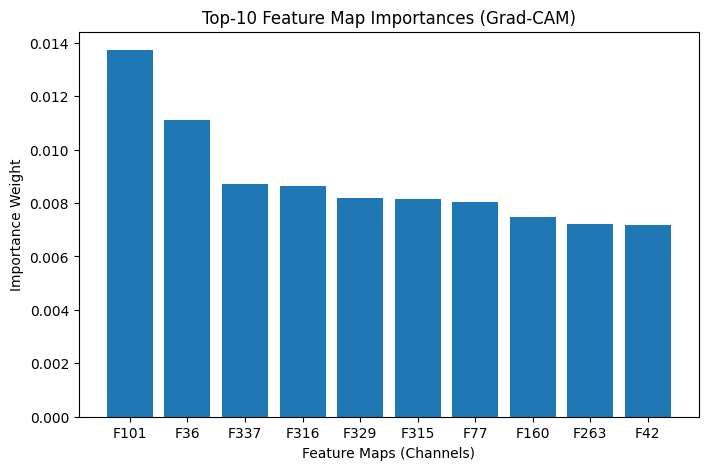

Predicted class: 1


In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def feature_importance_barplot(img_path, model, target_layer):
    preprocess = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    img = Image.open(img_path).convert("RGB")
    input_tensor = preprocess(img).unsqueeze(0).to(device)

    gradcam = GradCAM(model, target_layer)
    heatmap, pred_class = gradcam.generate(input_tensor)

    # Instead of full heatmap, compute channel-wise importance
    pooled_gradients = torch.mean(gradcam.gradients, dim=[0, 2, 3]).cpu().numpy()

    # Sort top 10 channels
    top_idx = np.argsort(pooled_gradients)[::-1][:10]
    top_vals = pooled_gradients[top_idx]

    # Plot bar chart
    plt.figure(figsize=(8,5))
    plt.bar(range(10), top_vals, tick_label=[f"F{i}" for i in top_idx])
    plt.title("Top-10 Feature Map Importances (Grad-CAM)")
    plt.ylabel("Importance Weight")
    plt.xlabel("Feature Maps (Channels)")
    plt.show()

    print(f"Predicted class: {pred_class}")

# ---------------- Run on a specific test image ----------------
img_path = r"D:\Research\kaggle-demo\data\test_images\0e052b0dec40.png"
target_layer = model.blocks[-1]
feature_importance_barplot(img_path, model, target_layer)


In [1]:
import torch
from efficientnet_pytorch import EfficientNet
import os

print("Attempting to fix model path...")

# Define the model architecture again to be safe
# Make sure the 'device' variable is available from previous cells
if 'device' not in globals():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device not found, setting to: {device}")

model_fix = EfficientNet.from_pretrained('efficientnet-b2', num_classes=5)

# Path to the model saved by the first training cell
original_model_path = "best_model.pth"

# The correct path where the Streamlit app expects the model
correct_model_path = "models/best_model_finetuned.pth"

# Ensure the 'models' directory exists
os.makedirs("models", exist_ok=True)

try:
    # Load the weights from the original model
    model_fix.load_state_dict(torch.load(original_model_path, map_location=device))
    
    # Save the weights to the correct path
    torch.save(model_fix.state_dict(), correct_model_path)
    
    print(f"✅ Success! Model has been copied to the correct location: {correct_model_path}")
    print("You can now try running the Streamlit app again.")

except FileNotFoundError:
    print(f"❌ Error: The initial model '{original_model_path}' was not found.")
    print("Please make sure you have run the first training cell (the one with 'num_epochs = 10') to create it.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Attempting to fix model path...
Device not found, setting to: cpu
Loaded pretrained weights for efficientnet-b2
✅ Success! Model has been copied to the correct location: models/best_model_finetuned.pth
You can now try running the Streamlit app again.
Loaded pretrained weights for efficientnet-b2
✅ Success! Model has been copied to the correct location: models/best_model_finetuned.pth
You can now try running the Streamlit app again.


In [25]:
import torch
from efficientnet_pytorch import EfficientNet
import os

print("Attempting to fix model path...")

# Define the model architecture again to be safe
# Make sure the 'device' variable is available from previous cells
if 'device' not in globals():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device not found, setting to: {device}")

model_fix = EfficientNet.from_pretrained('efficientnet-b2', num_classes=5)

# Path to the model saved by the first training cell
# This assumes 'best_model.pth' was created by Cell 11 in the project root.
original_model_path = "best_model.pth"

# The correct path where the Streamlit app expects the model
correct_model_path = "models/best_model_finetuned.pth"

# Ensure the 'models' directory exists
os.makedirs("models", exist_ok=True)

try:
    # Load the weights from the original model created by the first training run
    model_fix.load_state_dict(torch.load(original_model_path, map_location=device))
    
    # Save the weights to the correct path for the Streamlit app
    torch.save(model_fix.state_dict(), correct_model_path)
    
    print(f"✅ Success! Model has been copied to the correct location: {correct_model_path}")
    print("You can now try running the Streamlit app again.")

except FileNotFoundError:
    print(f"❌ Error: The initial model '{original_model_path}' was not found.")
    print("Please make sure you have run the first training cell (the one with 'num_epochs = 10') to create it.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


Attempting to fix model path...
Loaded pretrained weights for efficientnet-b2
Loaded pretrained weights for efficientnet-b2
✅ Success! Model has been copied to the correct location: models/best_model_finetuned.pth
You can now try running the Streamlit app again.
✅ Success! Model has been copied to the correct location: models/best_model_finetuned.pth
You can now try running the Streamlit app again.


In [26]:

import os
import shutil

# --- Final Attempt to Fix Model Path ---
# This cell will definitively move the model file.

source_path = "best_model.pth"
destination_dir = "models"
destination_path = os.path.join(destination_dir, "best_model_finetuned.pth")

# 1. Check if the source file exists
if os.path.exists(source_path):
    print(f"✅ Found the source model file: '{source_path}'")
    
    # 2. Ensure the destination directory exists
    os.makedirs(destination_dir, exist_ok=True)
    print(f"✅ Ensured the destination directory exists: '{destination_dir}'")
    
    # 3. Move and rename the file
    try:
        shutil.move(source_path, destination_path)
        print(f"✅✅✅ Successfully MOVED and RENAMED the model to: '{destination_path}'")
        print("\nPlease stop and restart the Streamlit app now.")
    except Exception as e:
        print(f"❌ An error occurred during the move: {e}")
        
else:
    print(f"❌ CRITICAL ERROR: The source model file '{source_path}' was not found in the project's root directory.")
    print("Please re-run the main training cell (Cell 11, with num_epochs=10) to generate it.")


✅ Found the source model file: 'best_model.pth'
✅ Ensured the destination directory exists: 'models'
✅✅✅ Successfully MOVED and RENAMED the model to: 'models\best_model_finetuned.pth'

Please stop and restart the Streamlit app now.
